In [1]:
%matplotlib inline

import pandas as pd, numpy as np, json, datetime, time, random, joblib, tqdm, csv
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import csv
import datetime

In [2]:
FILE_LOCATION = './data/2015_07_22_mktplace_shop_web_log_sample.log'

#Some Analysis in Pandas before we switch to PySpark#

In [3]:
%%time

# Read the CSV file
df = pd.read_csv(FILE_LOCATION, sep=' ', header=None, na_values=['-', ''],
                 error_bad_lines=False, warn_bad_lines=True)

# Assign column names
column_names = 'timestamp elb client:port backend:port request_processing_time backend_processing_time response_processing_time elb_status_code backend_status_code received_bytes sent_bytes request user_agent ssl_cipher ssl_protocol'
df.columns = column_names.split(' ')

# Adjust data format, index
df.timestamp = pd.to_datetime(df.timestamp)
df.sort_values(by='timestamp', inplace=True)
df.index = range(df.shape[0])

# Extract client IP & port
client_port = df['client:port'].str.split(':')
df['client'] = client_port.map(lambda x: x[0] if isinstance(x, list) else np.nan)
df['cport'] = client_port.map(lambda x: x[1] if isinstance(x, list) else np.nan)

# Extract backend IP & port
backend_port = df['backend:port'].str.split(':')
df['backend'] = backend_port.map(lambda x: x[0] if isinstance(x, list) else np.nan)
df['bport'] = backend_port.map(lambda x: x[1] if isinstance(x, list) else np.nan)    

# Extract the individual fields of the HTTP request 
request_data = df.request.str.split(' ')
df['method'] = request_data.map(lambda x: x[0])
df['url'] = request_data.map(lambda x: x[1])
df['protocol'] = request_data.map(lambda x: x[2])

# Hash the user-agent string
df['agent_hash'] = df.user_agent.map(lambda x: hashlib.md5(x).hexdigest() if isinstance(x, str) else np.nan)

print df.shape

Skipping line 491258: expected 15 fields, saw 16
Skipping line 491610: expected 15 fields, saw 16
Skipping line 491949: expected 15 fields, saw 16
Skipping line 492270: expected 15 fields, saw 16
Skipping line 492551: expected 15 fields, saw 16
Skipping line 492802: expected 15 fields, saw 16
Skipping line 493232: expected 15 fields, saw 16
Skipping line 496262: expected 15 fields, saw 16
Skipping line 496279: expected 15 fields, saw 16
Skipping line 496682: expected 15 fields, saw 16
Skipping line 496709: expected 15 fields, saw 16
Skipping line 496965: expected 15 fields, saw 16
Skipping line 497004: expected 15 fields, saw 16
Skipping line 497230: expected 15 fields, saw 16
Skipping line 497257: expected 15 fields, saw 16
Skipping line 497726: expected 15 fields, saw 16
Skipping line 497767: expected 15 fields, saw 16
Skipping line 497964: expected 15 fields, saw 16
Skipping line 497987: expected 15 fields, saw 16

Skipping line 547659: expected 15 fields, saw 16
Skipping line 55300

(1158478, 23)
CPU times: user 26.1 s, sys: 1.31 s, total: 27.4 s
Wall time: 27.3 s


In [4]:
df.head()

,timestamp,elb,client:port,backend:port,request_processing_time,backend_processing_time,response_processing_time,elb_status_code,backend_status_code,received_bytes,...,ssl_cipher,ssl_protocol,client,cport,backend,bport,method,url,protocol,agent_hash
0,2015-07-22 02:40:06.499174,marketpalce-shop,106.51.235.133:1813,10.0.6.158:80,0.000020,0.274619,0.000022,200,200,0,...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,106.51.235.133,1813,10.0.6.158,80,GET,https://paytm.com:443/shop/wallet/txnhistory?p...,HTTP/1.1,376956767818a23f320b0ffbb60a9092
1,2015-07-22 02:40:06.632589,marketpalce-shop,115.250.16.146:63523,10.0.4.227:80,0.000023,0.258738,0.000021,200,200,0,...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,115.250.16.146,63523,10.0.4.227,80,GET,https://paytm.com:443/shop/wallet/balance?chan...,HTTP/1.1,2c9343e055859b90ac580d7b16856af0
2,2015-07-22 02:40:06.633226,marketpalce-shop,106.51.235.133:1814,10.0.6.108:80,0.000021,0.066167,0.000020,200,200,0,...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,106.51.235.133,1814,10.0.6.108,80,GET,https://paytm.com:443/shop/wallet/balance?chan...,HTTP/1.1,376956767818a23f320b0ffbb60a9092
3,2015-07-22 02:40:06.700160,marketpalce-shop,52.74.219.71:43898,10.0.4.225:80,0.000020,0.004901,0.000023,200,200,0,...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,52.74.219.71,43898,10.0.4.225,80,GET,https://paytm.com:443/papi/v1/promosearch/prod...,HTTP/1.0,NaN
4,2015-07-22 02:40:06.734226,marketpalce-shop,27.97.124.172:31421,10.0.6.199:80,0.000024,0.004168,0.000024,200,200,0,...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,27.97.124.172,31421,10.0.6.199,80,GET,https://paytm.com:443/coupons,HTTP/1.1,1549acedb4c775b87d6d4ed430be645d


##Peak into of the data##

In [5]:
df.isnull().sum(axis=0)

timestamp                       0
elb                             0
client:port                     0
backend:port                  162
request_processing_time         0
backend_processing_time         0
response_processing_time        0
elb_status_code                 0
backend_status_code             0
received_bytes                  0
sent_bytes                      0
request                         0
user_agent                  40448
ssl_cipher                   8217
ssl_protocol                 8217
client                          0
cport                           0
backend                       162
bport                         162
method                          0
url                             0
protocol                        0
agent_hash                  40448
dtype: int64

In [6]:
df.describe()

,request_processing_time,backend_processing_time,response_processing_time,elb_status_code,backend_status_code,received_bytes,sent_bytes
count,1158478.000000,1158478.000000,1158478.000000,1158478.000000,1158478.000000,1158478.000000,1158478.000000
mean,-0.000117,0.033057,-0.000119,216.767441,216.696963,27.533324,5488.199179
std,0.011825,0.366028,0.011825,42.310138,42.251349,204.494768,15629.474198
min,-1.000000,-1.000000,-1.000000,200.000000,0.000000,0.000000,0.000000
25%,0.000021,0.002900,0.000020,200.000000,200.000000,0.000000,213.000000
50%,0.000023,0.004986,0.000021,200.000000,200.000000,0.000000,709.000000
75%,0.000024,0.012313,0.000022,200.000000,200.000000,0.000000,9518.000000
max,0.000151,58.698117,0.001433,504.000000,504.000000,23403.000000,1068957.000000


In [7]:
df.timestamp.head(5)

0   2015-07-22 02:40:06.499174
1   2015-07-22 02:40:06.632589
2   2015-07-22 02:40:06.633226
3   2015-07-22 02:40:06.700160
4   2015-07-22 02:40:06.734226
Name: timestamp, dtype: datetime64[ns]

In [8]:
df.timestamp.describe()

count                        1158478
unique                       1158250
top       2015-07-22 17:42:50.505759
freq                               2
first     2015-07-22 02:40:06.499174
last      2015-07-22 21:10:27.993803
Name: timestamp, dtype: object

#Digression before sessionization: understanding the frequency of requests#

In [9]:
timestamp_diff = df.timestamp.diff()[1:]
timestamp_diff /= np.timedelta64(1, 'ms')
print timestamp_diff.describe()
print
print timestamp_diff.head(5)

count    1158477.000000
mean          57.507827
std        17974.259736
min            0.000000
25%            0.756000
50%            1.985000
75%            4.298000
max      9619058.856000
Name: timestamp, dtype: float64

1    133.415
2      0.637
3     66.934
4     34.066
5     13.831
Name: timestamp, dtype: float64


In [10]:
timestamp_diff_sorted = timestamp_diff.sort_values()
print (timestamp_diff_sorted[timestamp_diff_sorted == 0]).shape
print (timestamp_diff_sorted[timestamp_diff_sorted > 10]).shape
print
print timestamp_diff_sorted.head(10)
print
print timestamp_diff_sorted.tail(10)

(228,)
(70468,)

552935     0
590742     0
542134     0
299985     0
832812     0
543125     0
442449     0
196926     0
543135     0
1094489    0
Name: timestamp, dtype: float64

653563     3027618.888
954071     3297028.545
653711     3898032.325
1132229    4795112.811
253567     5104284.840
1132326    5704847.740
89101      5942574.387
153568     7216342.806
26791      8644030.290
653912     9619058.856
Name: timestamp, dtype: float64


4.6993104 4.30526072 22.2667101 5.5363977 88.07799264 83.29798108 197.26553586 4.43017134 118.85852422 4.37372398


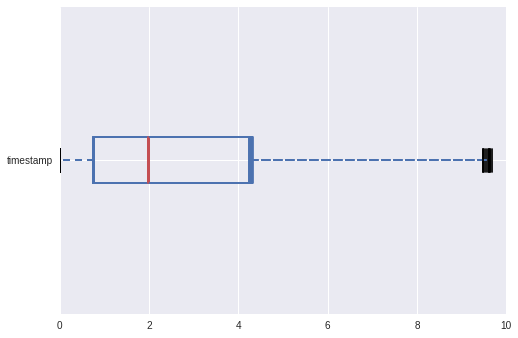

In [11]:
for _ in xrange(10):
    d_sample = timestamp_diff.sample(50000)
    d_sample.plot.box(showfliers=False, vert=False)
    print d_sample.mean(),

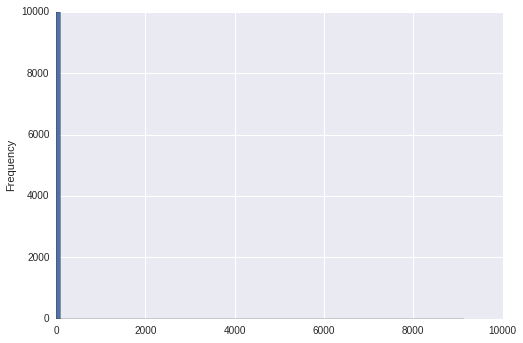

In [12]:
# Not so informative

d_sample = timestamp_diff.sample(10000)
d_sample.plot.hist(bins=100)

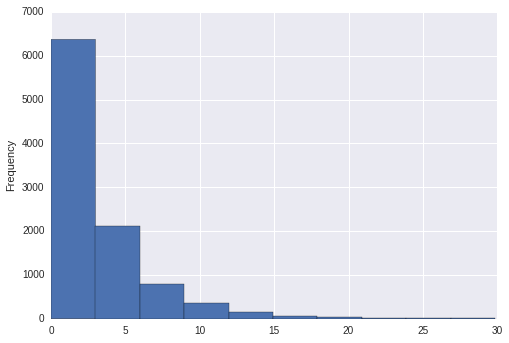

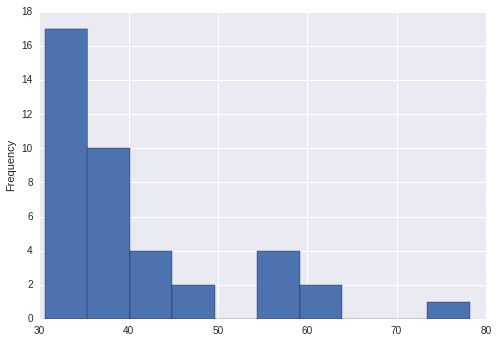

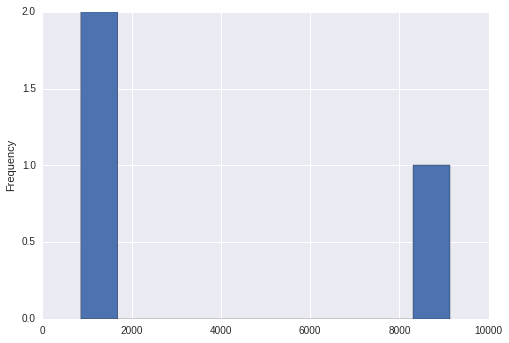

In [13]:
intervals = [0, 30, 200, timestamp_diff.max()]
for (l, u) in [(intervals[i], intervals[i+1]) for i in xrange(len(intervals) - 1)]:
    d_sample[(d_sample >= l) & (d_sample <= u)].plot.hist()
    plt.figure()

#End of digression#

In [14]:
df.head()

,timestamp,elb,client:port,backend:port,request_processing_time,backend_processing_time,response_processing_time,elb_status_code,backend_status_code,received_bytes,...,ssl_cipher,ssl_protocol,client,cport,backend,bport,method,url,protocol,agent_hash
0,2015-07-22 02:40:06.499174,marketpalce-shop,106.51.235.133:1813,10.0.6.158:80,0.000020,0.274619,0.000022,200,200,0,...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,106.51.235.133,1813,10.0.6.158,80,GET,https://paytm.com:443/shop/wallet/txnhistory?p...,HTTP/1.1,376956767818a23f320b0ffbb60a9092
1,2015-07-22 02:40:06.632589,marketpalce-shop,115.250.16.146:63523,10.0.4.227:80,0.000023,0.258738,0.000021,200,200,0,...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,115.250.16.146,63523,10.0.4.227,80,GET,https://paytm.com:443/shop/wallet/balance?chan...,HTTP/1.1,2c9343e055859b90ac580d7b16856af0
2,2015-07-22 02:40:06.633226,marketpalce-shop,106.51.235.133:1814,10.0.6.108:80,0.000021,0.066167,0.000020,200,200,0,...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,106.51.235.133,1814,10.0.6.108,80,GET,https://paytm.com:443/shop/wallet/balance?chan...,HTTP/1.1,376956767818a23f320b0ffbb60a9092
3,2015-07-22 02:40:06.700160,marketpalce-shop,52.74.219.71:43898,10.0.4.225:80,0.000020,0.004901,0.000023,200,200,0,...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,52.74.219.71,43898,10.0.4.225,80,GET,https://paytm.com:443/papi/v1/promosearch/prod...,HTTP/1.0,NaN
4,2015-07-22 02:40:06.734226,marketpalce-shop,27.97.124.172:31421,10.0.6.199:80,0.000024,0.004168,0.000024,200,200,0,...,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2,27.97.124.172,31421,10.0.6.199,80,GET,https://paytm.com:443/coupons,HTTP/1.1,1549acedb4c775b87d6d4ed430be645d


#What is a session?#

In [15]:
print 'Number of unique identifiers:'
data = [
    ['IP', len(df[['client']].drop_duplicates())],
    ['IP:port', len(df[['client', 'cport']].drop_duplicates())],
    ['IP & protocol', len(df[['client', 'protocol']].drop_duplicates())],
    ['IP & browser', len(df[['client', 'agent_hash']].drop_duplicates())],
    ['IP & browser & ssl', len(df[['client', 'agent_hash', 'ssl_cipher', 'ssl_protocol']].drop_duplicates())],
    ['IP & protocol & browser & ssl', len(df[['client', 'protocol', 'agent_hash', 'ssl_cipher', 'ssl_protocol']].drop_duplicates())]
]
pd.DataFrame(data)

Number of unique identifiers:


,0,1
0,IP,90544
1,IP:port,404385
2,IP & protocol,90595
3,IP & browser,112594
4,IP & browser & ssl,116819
5,IP & protocol & browser & ssl,116823


##So it makes sense to attempt identifying users with IP + browser info##

#The curious case of client 52.74.219.71#

http://ec2-52-74-219-71.ap-southeast-1.compute.amazonaws.com/

In [16]:
df.client.value_counts().sort_values(ascending=False).head(20)

52.74.219.71      40633
119.81.61.166     32829
106.186.23.95     14565
54.169.20.106      5538
54.169.0.163       5198
54.169.164.205     5174
112.196.25.164     5127
54.169.1.152       4917
106.51.132.54      4377
54.251.151.39      4003
54.169.106.125     3282
54.169.136.105     3163
52.74.59.227       2866
54.251.128.29      2810
54.169.64.74       2489
54.169.79.96       2242
54.169.77.128      2238
54.169.78.51       2081
54.169.192.103     2031
54.169.78.20       1820
Name: client, dtype: int64

In [17]:
singapore = df[df.client == '52.74.219.71'].copy()
singapore.shape[0]

40633

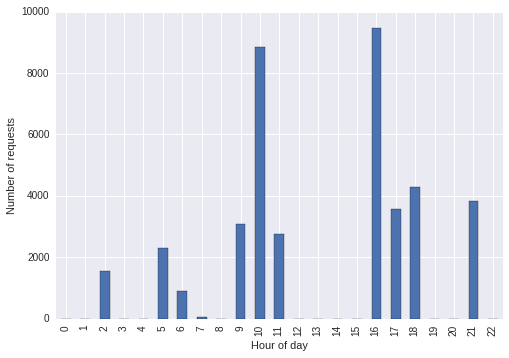

In [18]:
hours = singapore.groupby(singapore.timestamp.dt.hour).apply(lambda g: g.shape[0])
ax = hours.reindex(range(0, 23)).plot.bar()
_ = ax.set_xlabel('Hour of day')
_ = ax.set_ylabel('Number of requests')

##9000 = 2.5 requests per second##

In [19]:
print 'Number of unique ports:', singapore[['cport']].drop_duplicates().shape[0]
print 'Number of unique URLs:', singapore.url.unique().shape[0]

Number of unique ports: 21815
Number of unique URLs: 26423


In [20]:
singapore['timediff'] = singapore.timestamp.diff()
singapore['new_session'] = (singapore.timediff > np.timedelta64(10, 'm')).astype(int)
singapore.new_session.sum()

10

#bots#

In [21]:
singapore[['ssl_protocol', 'ssl_cipher', 'protocol', 'user_agent']].drop_duplicates()

,ssl_protocol,ssl_cipher,protocol,user_agent
3,TLSv1.2,ECDHE-RSA-AES128-GCM-SHA256,HTTP/1.0,NaN
748,TLSv1.2,ECDHE-RSA-AES128-GCM-SHA256,HTTP/1.1,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...


In [22]:
ua = df.user_agent.astype(str).str
bot_requests = df[['user_agent']][ua.contains('bot', case=False)]
print 'Number of bot requests:', bot_requests.shape[0]
print 'Number of bot agents:', bot_requests.drop_duplicates().shape[0]
bot_requests.drop_duplicates()

Number of bot requests: 25402
Number of bot agents: 34


,user_agent
38,Mozilla/5.0 (compatible; bingbot/2.0; +http://...
159,Slackbot 1.0 (+https://api.slack.com/robots)
292,Mozilla/5.0 (TweetmemeBot/4.0; +http://datasif...
342,Pingdom.com_bot_version_1.4_(http://www.pingdo...
748,Mozilla/5.0 (compatible; Googlebot/2.1; +http:...
1490,Pingdom.com_bot_version_1.4_(http://www.pingdo...
1973,Superfeedr bot/2.0 http://superfeedr.com - Mak...
5455,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
17017,Superfeedr bot/2.0 http://superfeedr.com - Mak...
17494,Mozilla/5.0 (iPhone; CPU iPhone OS 6_0 like Ma...


#Action?#

1. Delete any request from a user-agent which is a bot? Yes.

2. Delete any request from IP with known bot? No. Bots can operating behind the same ISP as legit users.

_Side question:_ Singapore? Can we throw away requests from outside India?

#Now we sessionize in PySpark#

In [25]:
column_names = 'timestamp elb client:port backend:port request_processing_time backend_processing_time response_processing_time elb_status_code backend_status_code received_bytes sent_bytes request user_agent ssl_cipher ssl_protocol method url protocol client cport'
column_names = column_names.split(' ')

# Keep track of the number of bad lines in the CSV (lines with incorrect number of fields)
n_bad_lines = sc.accumulator(0)
correct_n_cols = sc.broadcast(len(column_names))

def csv_parse(line):
    '''
    Parse each line in the CSV file
    Return list of fields
    '''
    global n_bad_lines
    try:
        parsed_line = next(csv.reader([line], delimiter=' '))
        parsed_line[0] = pd.to_datetime(parsed_line[0])
        parsed_line += parsed_line[-4].split(' ') # Extract HTTP protocol
        parsed_line += parsed_line[2].split(':') # Extract client IP & port
        if len(parsed_line) != correct_n_cols.value:
            n_bad_lines += 1
        return parsed_line
    except Exception as e:
        print e
        return [''] * len(column_names)

# Read and parse CSV file. Ignore bad lines
log_file = sc.textFile(FILE_LOCATION)\
    .map(csv_parse)\
    .filter(lambda row: len(row) == len(column_names))\
    .cache()

print n_bad_lines.value

0


In [26]:
print log_file.count()
print n_bad_lines.value

1158478
22


In [27]:
log_file.take(2)

[[Timestamp('2015-07-22 09:00:28.019143'),
  'marketpalce-shop',
  '123.242.248.130:54635',
  '10.0.6.158:80',
  '0.000022',
  '0.026109',
  '0.00002',
  '200',
  '200',
  '0',
  '699',
  'GET https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null HTTP/1.1',
  'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.130 Safari/537.36',
  'ECDHE-RSA-AES128-GCM-SHA256',
  'TLSv1.2',
  'GET',
  'https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null',
  'HTTP/1.1',
  '123.242.248.130',
  '54635'],
 [Timestamp('2015-07-22 09:00:27.894580'),
  'marketpalce-shop',
  '203.91.211.44:51402',
  '10.0.4.150:80',
  '0.000024',
  '0.15334',
  '0.000026',
  '200',
  '200',
  '0',
  '1497',
  'GET https://paytm.com:443/shop/wallet/txnhistory?page_size=10&page_number=0&channel=web&version=2 HTTP/1.1',
  'Mozilla/5.0 (Windows NT 6.1; rv:39.0) Gecko/20100101 Firefox/39.0',
  'ECDHE-RSA-AES128-

##Sessionization function (batch)##

In [28]:
def sessionize(key_request_list, session_limit):   
    key = key_request_list[0]
    request_list = key_request_list[1].data
    # Sort requests by timestamp
    request_list.sort(key=lambda x: x[0])
    session_list = []

    session_counter = 0
    session_id = lambda: '%s_%s' % (key, session_counter)
    
    current_session_id = session_id()
    current_length = 0
    current_urls = set()
    
    url = request_list[0][-4]
    current_urls.add(url)
    
    for i in xrange(1, len(request_list)):
        url = request_list[i][-4]
        duration = (request_list[i][0] - request_list[i-1][0]).total_seconds()
        if duration <= session_limit:
            current_length += duration
            current_urls.add(url)
        else:
            session_list.append((current_session_id, (current_length, current_urls)))
            session_counter += 1
            current_session_id = session_id()
            current_length = 0
            current_urls = set(url)

    session_list.append((current_session_id, (current_length, current_urls)))

    return session_list

In [29]:
SESSION_LIMIT = 15*60

# Group request by IP
requests_by_ip = log_file.groupBy(lambda l: l[-2])

# Convert each group into a list of sessions
sessions = requests_by_ip.flatMap(lambda kv: sessionize(kv, SESSION_LIMIT)).cache()

###Collect sessions for analysis###

In [30]:
sessions.take(1)

[('111.93.191.38_0',
  (97.14414800000002,
   {'https://paytm.com:443/shop/authresponse?code=cb99c680-ba4c-40e5-b460-3b9128a5a7b9',
    'https://paytm.com:443/shop/cart',
    'https://paytm.com:443/shop/cart/checkout?channel=web&version=2',
    'https://paytm.com:443/shop/cart?channel=web&version=2',
    'https://paytm.com:443/shop/login?isIframe=true&theme=mp-web',
    'https://paytm.com:443/shop/user/address',
    'https://paytm.com:443/shop/user/address?channel=web&version=2',
    'https://paytm.com:443/shop/v1/frequentorders?channel=web&version=2'}))]

In [31]:
data = sessions.map(lambda kv: (kv[0], kv[0].split('_')[0], kv[1][0], kv[1][1])).collect()
session_summary = pd.DataFrame(data, columns=['session_id', 'ip', 'seconds', 'urls'])
print 'Number of sessions:', session_summary.shape[0]
session_summary.sort_values(by='seconds', ascending=False, inplace=True)
session_summary['readable_length'] = session_summary.seconds.map(lambda x: pd.Timedelta(x, 's'))
session_summary['n_urls'] = session_summary['urls'].map(len)

Number of sessions: 110838


In [32]:
session_summary.head(10)

,session_id,ip,seconds,urls,readable_length,n_urls
4944,52.74.219.71_4,52.74.219.71,2069.161909,{https://paytm.com:443/shop/p/yonex-carbonex-6...,00:34:29.161909,9573
86073,119.81.61.166_4,119.81.61.166,2068.848450,{https://paytm.com:443/papi//v1/promosearch/pr...,00:34:28.848450,1770
96289,106.186.23.95_4,106.186.23.95,2068.756402,{https://paytm.com:443/papi/v1/promosearch/pro...,00:34:28.756402,2763
20962,125.19.44.66_4,125.19.44.66,2068.712470,{https://paytm.com:443/shop/orderdetail/111659...,00:34:28.712470,488
93286,125.20.39.66_3,125.20.39.66,2068.320635,{https://paytm.com:443/papi/rr/products/535608...,00:34:28.320635,255
69603,192.8.190.10_2,192.8.190.10,2067.234329,{https://paytm.com:443/papi/rr/products/287399...,00:34:27.234329,142
108129,54.251.151.39_4,54.251.151.39,2067.022968,"{a, c, https://paytm.com:443/blog/wp-cron.php?...",00:34:27.022968,21
72531,180.211.69.209_3,180.211.69.209,2066.960642,"{https://paytm.com:443/scripts/paytmAd.js, htt...",00:34:26.960642,89
35128,180.179.213.70_4,180.179.213.70,2065.637990,{http://paytm.com:80/shop/p/lenovo-idea-tab-a1...,00:34:25.637990,160
55236,203.189.176.14_4,203.189.176.14,2065.594344,{https://paytm.com:443/papi/rr/products/128192...,00:34:25.594344,78


##Average Session length##

###In Spark###

In [33]:
sessions.map(lambda kv: kv[1][0]).mean()

100.72750948187446

###In Pandas###

In [34]:
session_summary.readable_length.describe()

count                    110838
mean     0 days 00:01:40.727509
std      0 days 00:03:49.883921
min             0 days 00:00:00
25%      0 days 00:00:00.713340
50%      0 days 00:00:19.204106
75%      0 days 00:01:41.088087
max      0 days 00:34:29.161909
Name: readable_length, dtype: object

##Most engaged users (IPs with longest sessions)##

In [35]:
ip_max_session = session_summary.groupby('ip')['seconds'].max()
ip_max_session.sort_values(ascending=False).head(10)

ip
52.74.219.71      2069.161909
119.81.61.166     2068.848450
106.186.23.95     2068.756402
125.19.44.66      2068.712470
125.20.39.66      2068.320635
192.8.190.10      2067.234329
54.251.151.39     2067.022968
180.211.69.209    2066.960642
180.179.213.70    2065.637990
203.189.176.14    2065.594344
Name: seconds, dtype: float64